In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

In [19]:
path = "/kaggle/input/utkface-new/UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

Total samples: 23708
26_0_2_20170104023102422.jpg.chip.jpg


In [20]:
import cv2
images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

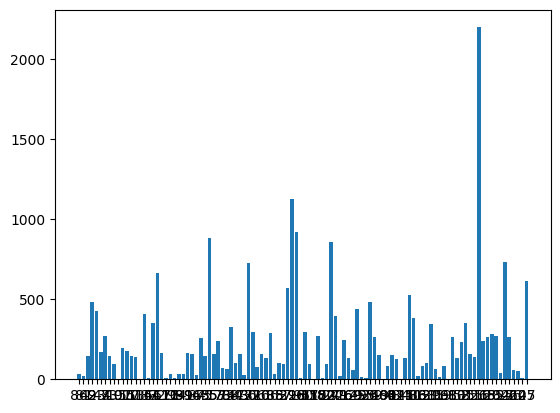

Max value: 99


In [21]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

Gender: 0 Age: 54


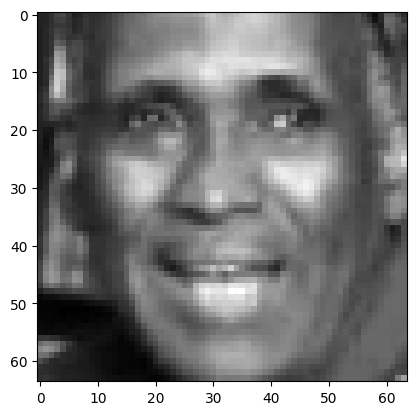

In [22]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("Gender:",genders[idx],"Age:",ages[idx])
display(sample)

In [23]:
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

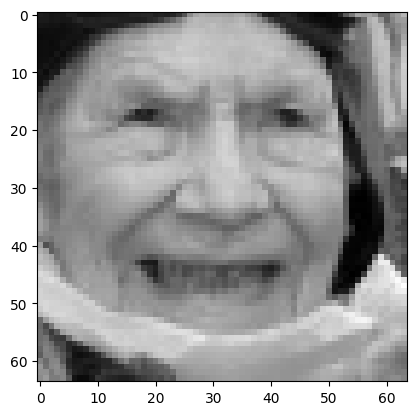

In [24]:
# pre processing
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size):
    target[i,0] = age_group(int(ages[i])) / 4
    target[i,1] = int(genders[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [25]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18966
Samples in Testing: 4742


In [26]:

import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [27]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

inputs = Input(shape=(64, 64, 1))
conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv3)
x = Dropout(0.25)(pool2)
x = BatchNormalization()(x)
flat = Flatten()(x)

# Age Model
dropout = Dropout(0.5)
age_model = Dense(128, activation='relu')(flat)
age_model = BatchNormalization()(age_model)
age_model = dropout(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = BatchNormalization()(age_model)
age_model = dropout(age_model)
age_model = Dense(32, activation='relu')(age_model)
age_model = BatchNormalization()(age_model)
age_model = dropout(age_model)
age_model = Dense(1, activation='relu')(age_model)

# Gender Model
dropout = Dropout(0.5)
gender_model = Dense(128, activation='relu')(flat)
gender_model = BatchNormalization()(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(64, activation='relu')(gender_model)
gender_model = BatchNormalization()(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(32, activation='relu')(gender_model)
gender_model = BatchNormalization()(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(16, activation='relu')(gender_model)
gender_model = BatchNormalization()(gender_model)
gender_model = dropout(gender_model)
gender_model = Dense(8, activation='relu')(gender_model)
gender_model = BatchNormalization()(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)




In [28]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['accuracy'])
model.summary()
h = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),epochs = 50, batch_size=128,shuffle = True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 62, 62, 32)           320       ['input_4[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 60, 60, 64)           18496     ['conv2d_9[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 64)           0         ['conv2d_10[0][0]']           
 g2D)                                                                                       

2023-12-10 09:26:05.348229: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


149/149 [==============================] - 14s 39ms/step - loss: 1.4564 - dense_37_loss: 0.6929 - dense_43_loss: 0.7635 - dense_37_accuracy: 0.0075 - dense_43_accuracy: 0.5947 - val_loss: 1.0143 - val_dense_37_loss: 0.3198 - val_dense_43_loss: 0.6945 - val_dense_37_accuracy: 0.0000e+00 - val_dense_43_accuracy: 0.5702
Epoch 2/50
149/149 [==============================] - 5s 36ms/step - loss: 0.9624 - dense_37_loss: 0.3604 - dense_43_loss: 0.6020 - dense_37_accuracy: 0.0057 - dense_43_accuracy: 0.6798 - val_loss: 1.1169 - val_dense_37_loss: 0.3847 - val_dense_43_loss: 0.7323 - val_dense_37_accuracy: 0.0000e+00 - val_dense_43_accuracy: 0.5411
Epoch 3/50
149/149 [==============================] - 5s 35ms/step - loss: 0.8637 - dense_37_loss: 0.3145 - dense_43_loss: 0.5492 - dense_37_accuracy: 0.0066 - dense_43_accuracy: 0.7313 - val_loss: 0.9156 - val_dense_37_loss: 0.3378 - val_dense_43_loss: 0.5778 - val_dense_37_accuracy: 0.0000e+00 - val_dense_43_accuracy: 0.6898
Epoch 4/50
149/149 [===

In [29]:
# Assuming your model is defined as follows:
# model = Model(inputs=inputs, outputs=[age_model, gender_model])
# model.compile(optimizer='adam', loss=['mse', 'binary_crossentropy'], metrics=['accuracy'])

# Evaluate the model on the test data
eval_results = model.evaluate(x_test, [y_test[:, 0], y_test[:, 1]], batch_size=128)

# Print the evaluation results
print("Test Age Model Accuracy:", eval_results[3])  # Replace 'age_model_accuracy' with the actual name of the age output layer
print("Test Gender Model Accuracy:", eval_results[4])  # Replace 'gender_model_accuracy' with the actual name of the gender output layer


38/38 [==============================] - 0s 8ms/step - loss: 0.3265 - dense_37_loss: 0.0163 - dense_43_loss: 0.3101 - dense_37_accuracy: 0.0257 - dense_43_accuracy: 0.8971
Test Age Model Accuracy: 0.025727540254592896
Test Gender Model Accuracy: 0.8970898389816284


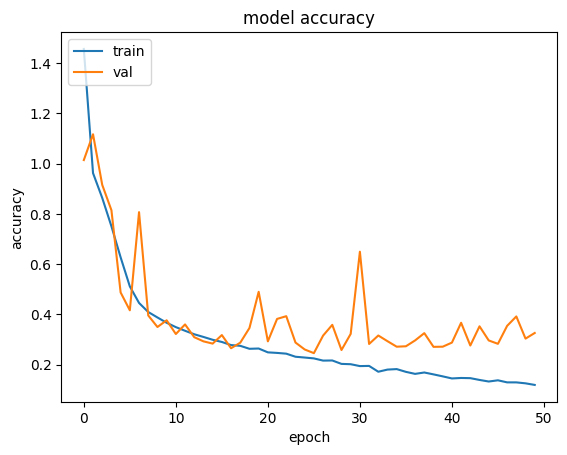

In [30]:
model.save('data.h5')
history = h
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


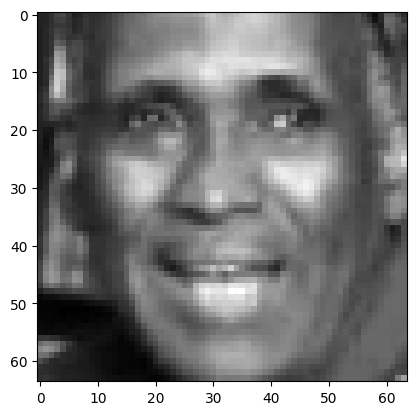

Actual Gender: Male Age: 54
1/1 [==============================] - 0s 290ms/step
Values: [array([[0.]], dtype=float32), array([[0.51660746]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


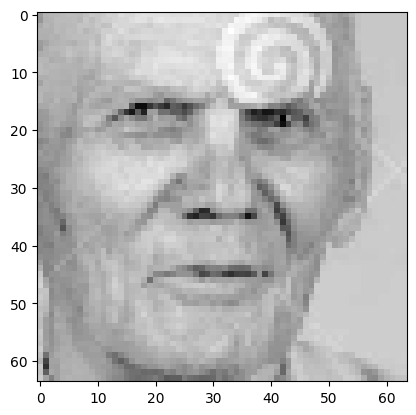

Actual Gender: Male Age: 82
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.]], dtype=float32), array([[0.8384068]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


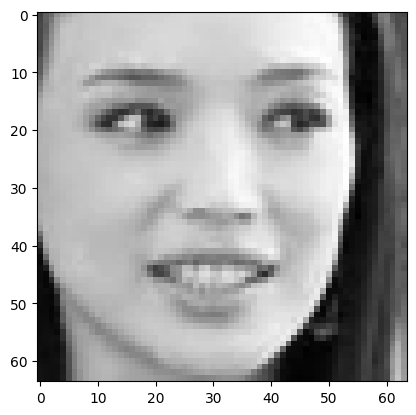

Actual Gender: Female Age: 24
1/1 [==============================] - 0s 24ms/step
Values: [array([[0.]], dtype=float32), array([[0.90032643]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


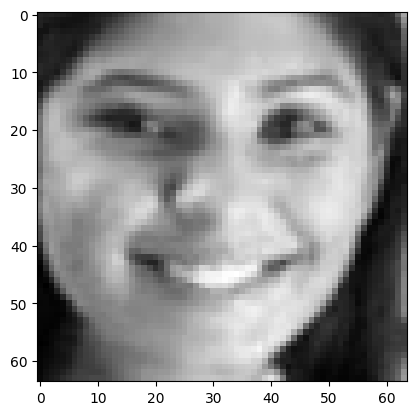

Actual Gender: Female Age: 21
1/1 [==============================] - 0s 23ms/step
Values: [array([[0.]], dtype=float32), array([[0.61352074]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


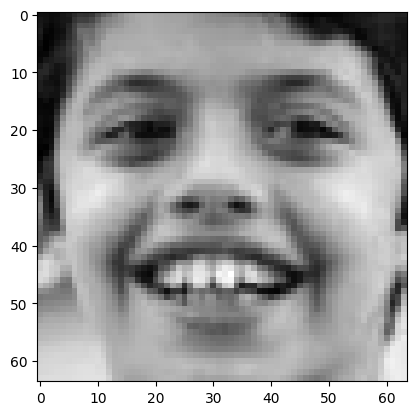

Actual Gender: Male Age: 7
1/1 [==============================] - 0s 20ms/step
Values: [array([[0.]], dtype=float32), array([[0.7418734]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


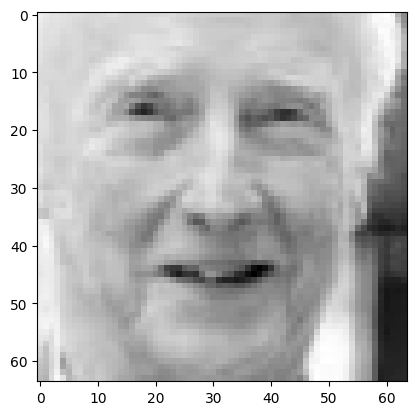

Actual Gender: Male Age: 76
1/1 [==============================] - 0s 22ms/step
Values: [array([[0.]], dtype=float32), array([[0.789792]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


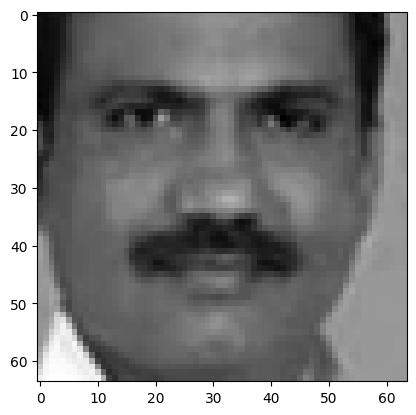

Actual Gender: Male Age: 34
1/1 [==============================] - 0s 23ms/step
Values: [array([[0.]], dtype=float32), array([[0.5524722]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


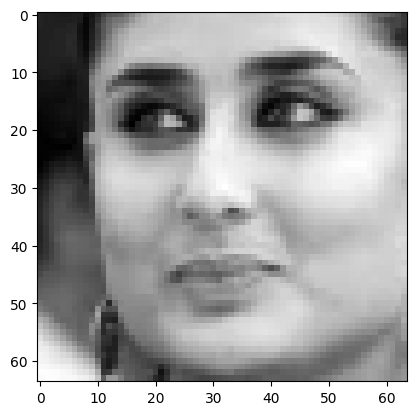

Actual Gender: Female Age: 25
1/1 [==============================] - 0s 21ms/step
Values: [array([[0.]], dtype=float32), array([[0.6523874]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


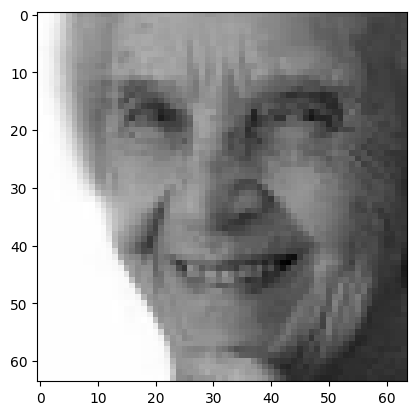

Actual Gender: Female Age: 79
1/1 [==============================] - 0s 23ms/step
Values: [array([[0.]], dtype=float32), array([[0.98856527]], dtype=float32)] 
Predicted Gender: Female Predicted Age: Unknown


In [31]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = get_age(val[0])
    gender = get_gender(val[1])
    print("Values:",val,"\nPredicted Gender:",gender,"Predicted Age:",age)
    
    
indexes = [500,59,80,2,4546,7,9,256,45]
for idx in indexes:
    sample = images[idx]
    display(sample)
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    res = get_result(sample)

